<a href="https://colab.research.google.com/github/anasnafis77/Deteksi-Glaukoma/blob/main/Semantic_segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("ggplot")
%matplotlib inline

from ipywidgets import interact
from tqdm import tqdm_notebook, tnrange
from itertools import chain
from skimage.io import imread, imshow, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
from sklearn.model_selection import train_test_split

import tensorflow as tf

from keras.models import Model, load_model
from keras.layers import Input, BatchNormalization, Activation, Dense, Dropout, Lambda
from keras.layers.core import Lambda, RepeatVector, Reshape
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D, GlobalMaxPool2D
from keras.layers.merge import concatenate, add
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
import cv2
from google.colab import drive
from keras import backend as K
from PIL import Image

In [2]:
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
df = pd.read_json('/content/gdrive/My Drive/Drive Tugas Akhir/Kode/dataframe.json')

In [ ]:
df.groupby(['dataset', 'tag']).size()

dataset  tag     
drishti  Glaucoma     32
         Normal       18
refuge   Glaucoma     40
         Normal      360
dtype: int64

# Misc

In [ ]:
H_OD = np.array([])
H_OC = np.array([])
W_OD = np.array([])
W_OC = np.array([])
for i in range(len(df)):
  OD_mask = cv2.imread(df['path_OD_png'][i], 0)
  OC_mask = cv2.imread(df['path_OC_png'][i], 0)
  OD_mask,_ = cv2.findContours(OD_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
  OC_mask,_ = cv2.findContours(OC_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
  OD_mask = cv2.approxPolyDP(OD_mask[0], 3, True)
  OC_mask = cv2.approxPolyDP(OC_mask[0], 3, True)
  _, _, w_OD, h_OD = cv2.boundingRect(OD_mask)
  _, _, w_OC, h_OC = cv2.boundingRect(OC_mask)
  H_OD = np.append(H_OD, h_OD)
  H_OC = np.append(H_OC, h_OC)
  W_OD = np.append(W_OD, w_OD)
  W_OC = np.append(W_OC, w_OC)

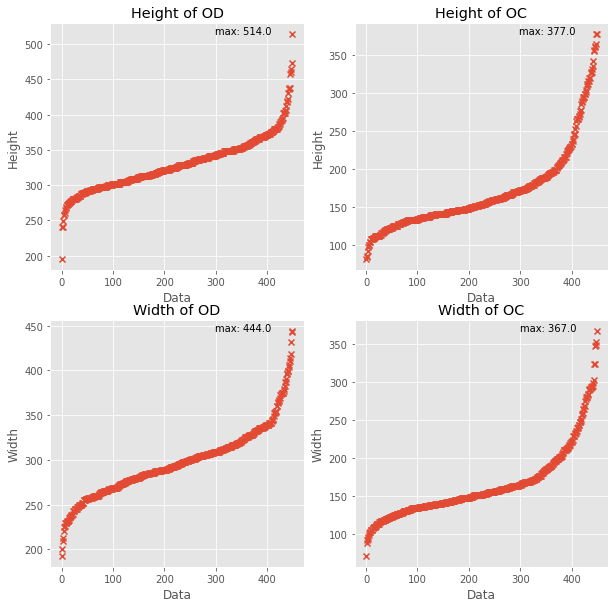

In [ ]:
H_OD = np.sort(H_OD, axis=0)
H_OC = np.sort(H_OC, axis=0)
W_OD = np.sort(W_OD, axis=0)
W_OC = np.sort(W_OC, axis=0)
plt.figure(figsize=(10,10))
plt.subplot(221), 
plt.scatter(list(range(len(df))), H_OD, marker='x')
plt.title('Height of OD')
plt.text(np.argmax(H_OD)-150, np.max(H_OD), 'max: {}'.format(np.max(H_OD)))
plt.xlabel('Data')
plt.ylabel('Height')
plt.subplot(222),
plt.scatter(list(range(len(df))), H_OC, marker='x')
plt.title('Height of OC')
plt.text(np.argmax(H_OC)-150, np.max(H_OC), 'max: {}'.format(np.max(H_OC)))
plt.xlabel('Data')
plt.ylabel('Height')
plt.subplot(223),
plt.scatter(list(range(len(df))), W_OD, marker='x')
plt.title('Width of OD')
plt.text(np.argmax(W_OD)-150, np.max(W_OD), 'max: {}'.format(np.max(W_OD)))
plt.xlabel('Data')
plt.ylabel('Width')
plt.subplot(224),
plt.scatter(list(range(len(df))), W_OC, marker='x')
plt.title('Width of OC')
plt.text(np.argmax(W_OC)-150, np.max(W_OC), 'max: {}'.format(np.max(W_OC)))
plt.xlabel('Data')
plt.ylabel('Width')
plt.show()

In [ ]:
error_OD = []
error_OC = []
for i in range(len(df)):
  img_OD = cv2.imread(df['path_OD_png'][5], 0)
  img_OD,_ = ekstrakROI(df['disc_center'][5], 550, img_OD)
  img1_OD = img_OD/255.0
  
  img2_OD = downscale(img1_OD)
  img3_OD = upscale(img2_OD)
  #img2_OD = cv2.resize(img1_OD, (256, 256), interpolation = cv2.INTER_CUBIC)
  #img3_OD = cv2.resize(img2_OD, (550, 550), interpolation = cv2.INTER_CUBIC)
  #
  #img3_OD = resize(img2_OD, (550, 550), mode = 'constant', preserve_range = True)
  
  img3_OD = img3_OD>0.5

  img_OC = cv2.imread(df['path_OC_png'][5], 0)
  img_OC,_ = ekstrakROI(df['disc_center'][5], 550, img_OC)
  img1_OC = img_OC/255.0

  img2_OC = downscale(img1_OC)
  img3_OC = upscale(img2_OC)
  #img2_OC = cv2.resize(img1_OC, (256, 256), interpolation = cv2.INTER_CUBIC)
  #img3_OC = cv2.resize(img2_OC, (550, 550), interpolation = cv2.INTER_CUBIC)
  #
  #img3_OC = resize(img2_OC, (550, 550), mode = 'constant', preserve_range = True)
  
  img3_OC = img3_OC>0.5

  DSC_OD = np.sum(img3_OD[img1_OD==1.0])*2.0 / (np.sum(img3_OD) + np.sum(img1_OD))
  DSC_OC = np.sum(img3_OC[img1_OC==1.0])*2.0 / (np.sum(img3_OC) + np.sum(img1_OC))

  error_OD.append(1-DSC_OD)
  error_OC.append(1-DSC_OC)

error_OD = np.array(error_OD)
error_OC = np.array(error_OC)
print('Mean error dari resizing OD: {:.6f}'.format(np.mean(error_OD)))
print('STD error dari resizing OD: {:.6f}'.format(np.std(error_OD)))
print('Mean error dari resizing OC: {:.6f}'.format(np.mean(error_OC)))
print('STD error dari resizing OC: {:.6f}'.format(np.std(error_OC)))

Mean error dari resizing OD: 0.000571
STD error dari resizing OD: 0.000000
Mean error dari resizing OC: 0.000656
STD error dari resizing OC: 0.000000


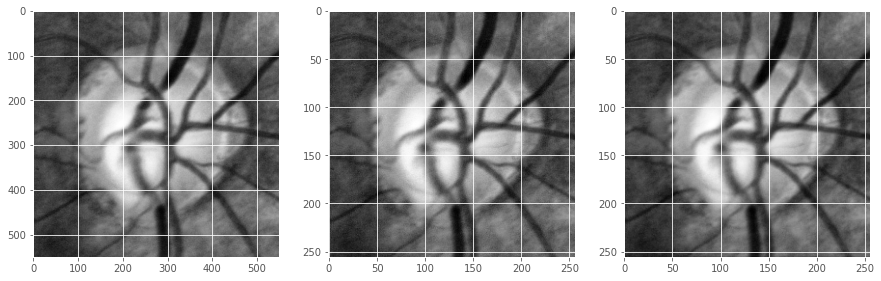

In [ ]:
img = cv2.imread(df['path'][1], 1)[:,:,1]
center = df['disc_center'][1]
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
img = clahe.apply(img)
img,_ = ekstrakROI(center, 550, img)
img1 = downscale(img.reshape(550, 550, 1))
img2 = resize(img, (256, 256), mode = 'constant', preserve_range = True)
plt.figure(figsize=(15, 5))
plt.subplot(131), plt.imshow(img, cmap='gray')
plt.subplot(132), plt.imshow(img1.numpy().squeeze(), cmap='gray')
plt.subplot(133), plt.imshow(img2, cmap='gray')
plt.show()


# Functions

In [4]:
def rectfromcenter(center, s, h, w):
  x, y = center
  x0 = round(x - 0.5*s)
  x1 = round(x + 0.5*s)
  y0 = round(y - 0.5*s)
  y1 = round(y + 0.5*s)
  dx = (x1 - x0) - s
  dy = (y1 - y0) - s
  # penanganan kasus out of image
  if (x0 < 0):
    x1 = x1 + (-x0)
    x0 = 0
    x1 -= dx
  elif (x1 > w-1):
    x0 = x0 - (x1-(w-1))
    x1 = w-1
    x0 += dx
  else:
    x0 += dx

  if (y0 < 0):
    y1 = y1 + (-y0)
    y0 = 0
    y1 -= dy
  elif (y1 > h-1):
    y0 = y0 - (y1-(h-1))
    y1 = (h-1)
    y0 += dy
  else:
    y0 += dy

  return y0, y1, x0, x1

In [5]:
# Fungsi untuk mengekstrak ROI
# input : list centroid, panjang sisi ROI (s), dan image 
# output : ROI image

def ekstrakROI(centroid, s, img):
  h, w = img.shape[:2]
 
  y0, y1, x0, x1 = rectfromcenter(centroid, s, h, w)

  #cropping ROI from source image
  ROI = img[y0:y1, x0:x1]
  koordinat = (y0, y1, x0, x1)

  return ROI, koordinat

In [6]:
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def fscore(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [7]:
def histo(histories):
  for i, histori in enumerate(histories):
    plt.figure(figsize=(20, 5))
    print('Fold-{}'.format(i+1))
    plt.subplot(131), 
    plt.plot(histori.history["accuracy"], label="accuracy")
    plt.plot(histori.history["val_accuracy"], label="val_acc")
    plt.plot(np.argmax(histori.history["val_accuracy"]), np.max(histori.history["val_accuracy"]), marker="x", color="r", label="best model")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.subplot(132), 
    plt.plot(histori.history["fscore"], label="fscore")
    plt.plot(histori.history["val_fscore"], label="val_fscore")
    plt.plot( np.argmax(histori.history["val_fscore"]), np.max(histori.history["val_fscore"]), marker="x", color="r", label="best model")
    plt.xlabel("Epochs")
    plt.ylabel("Fscore")
    plt.legend()
    plt.subplot(133),
    plt.plot(histori.history["loss"], label="loss")
    plt.plot(histori.history["val_loss"], label="val_loss")
    plt.plot( np.argmin(histori.history["val_loss"]), np.min(histori.history["val_loss"]), marker="x", color="r", label="best model")
    plt.xlabel("Epochs")
    plt.ylabel("log_loss")
    plt.legend()

    plt.show()

In [8]:
def downscale(img):
    size = (256, 256)
    img = tf.image.resize(img, size, method=tf.image.ResizeMethod.BICUBIC, preserve_aspect_ratio=True)
    return img

def upscale(img):
  size = (550, 550)
  img = tf.image.resize(img, size, method=tf.image.ResizeMethod.BICUBIC, preserve_aspect_ratio=True)

  return img

In [9]:
def conv2d_block(input_tensor, n_filters, kernel_size = 3, batchnorm = True):
    """Function to add 2 convolutional layers with the parameters passed to it"""
    # first layer
    x = Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),\
              kernel_initializer = 'he_normal', padding = 'same')(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    # second layer
    x = Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),\
              kernel_initializer = 'he_normal', padding = 'same')(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    return x
  
def get_unet(input_img, n_filters = 16, dropout = 0.1, batchnorm = True):
    # Contracting Path
    
    c1 = conv2d_block(input_img, n_filters * 1, kernel_size = 3, batchnorm = batchnorm)
    p1 = MaxPooling2D((2, 2))(c1)
    p1 = Dropout(dropout)(p1)
    
    c2 = conv2d_block(p1, n_filters * 2, kernel_size = 3, batchnorm = batchnorm)
    p2 = MaxPooling2D((2, 2))(c2)
    p2 = Dropout(dropout)(p2)
    
    c3 = conv2d_block(p2, n_filters * 4, kernel_size = 3, batchnorm = batchnorm)
    p3 = MaxPooling2D((2, 2))(c3)
    p3 = Dropout(dropout)(p3)
    
    c4 = conv2d_block(p3, n_filters * 8, kernel_size = 3, batchnorm = batchnorm)
    p4 = MaxPooling2D((2, 2))(c4)
    p4 = Dropout(dropout)(p4)
    
    c5 = conv2d_block(p4, n_filters = n_filters * 16, kernel_size = 3, batchnorm = batchnorm)
    
    # Expansive Path
    u6 = Conv2DTranspose(n_filters * 8, (3, 3), strides = (2, 2), padding = 'same')(c5)
    u6 = concatenate([u6, c4])
    u6 = Dropout(dropout)(u6)
    c6 = conv2d_block(u6, n_filters * 8, kernel_size = 3, batchnorm = batchnorm)
    
    u7 = Conv2DTranspose(n_filters * 4, (3, 3), strides = (2, 2), padding = 'same')(c6)
    u7 = concatenate([u7, c3])
    u7 = Dropout(dropout)(u7)
    c7 = conv2d_block(u7, n_filters * 4, kernel_size = 3, batchnorm = batchnorm)
    
    u8 = Conv2DTranspose(n_filters * 2, (3, 3), strides = (2, 2), padding = 'same')(c7)
    u8 = concatenate([u8, c2])
    u8 = Dropout(dropout)(u8)
    c8 = conv2d_block(u8, n_filters * 2, kernel_size = 3, batchnorm = batchnorm)
    
    u9 = Conv2DTranspose(n_filters * 1, (3, 3), strides = (2, 2), padding = 'same')(c8)
    u9 = concatenate([u9, c1])
    u9 = Dropout(dropout)(u9)
    c9 = conv2d_block(u9, n_filters * 1, kernel_size = 3, batchnorm = batchnorm)
    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c9)
    
    
    model = Model(inputs=[input_img], outputs=[outputs])
    return model

In [10]:
def index_shuffle(f, random_state=4):
  ix_dr_gl = np.array(list(range(0, 32)))
  ix_dr_n = np.array(list(range(32, 50)))
  ix_re_gl = np.array(list(range(50, 90)))
  ix_re_n = np.array(list(range(90, 450)))
  
  random.Random(random_state).shuffle(ix_dr_gl)
  random.Random(random_state).shuffle(ix_dr_n)
  random.Random(random_state).shuffle(ix_re_gl)
  random.Random(random_state).shuffle(ix_re_n)

  dr_gl = np.array([0, 6, 12, 18, 25, 32]) # portion of each fold for drishti-glaucoma data
  dr_n = np.array([0, 3, 6, 10, 14, 18]) # portion of each fold for drishti-normal data
  re_gl = np.array([0, 8, 16, 24, 32, 40]) # portion of each fold for refuge-glaucoma data
  re_n = np.array([0, 72, 144, 216, 288, 360]) # portion of each fold for refuge-normal data
  
  i = f - 1
  # meta-index for train data
  tr_dr_gl = list(range(dr_gl[i])) + list(range(dr_gl[i+1], 32))
  tr_dr_n = list(range(dr_n[i])) + list(range(dr_n[i+1], 18))
  tr_re_gl = list(range(re_gl[i])) + list(range(re_gl[i+1], 40))
  tr_re_n = list(range(re_n[i])) + list(range(re_n[i+1], 360))

  # meta-index for test data
  te_dr_gl = list(range(dr_gl[i], dr_gl[i+1])) 
  te_dr_n = list(range(dr_n[i], dr_n[i+1]))
  te_re_gl = list(range(re_gl[i], re_gl[i+1]))
  te_re_n = list(range(re_n[i], re_n[i+1]))

  ix_train = np.concatenate((ix_dr_gl[tr_dr_gl], ix_dr_n[tr_dr_n],
                               ix_re_gl[tr_re_gl], ix_re_n[tr_re_n]))
  ix_test = np.concatenate((ix_dr_gl[te_dr_gl], ix_dr_n[te_dr_n],
                              ix_re_gl[te_re_gl],  ix_re_n[te_re_n]))
  
  random.Random(random_state).shuffle(ix_train)
  random.Random(random_state).shuffle(ix_test)


  return ix_train, ix_test

In [11]:
def data_shuffle(X, y, f, random_state=4):
  # Mengembablikan data X dan y menjadi data yang siap untuk mentrain dan test model
  # pada fold ke - f

  ix_train, ix_test = index_shuffle(f=f)
  X_train = X[ix_train]
  X_test = X[ix_test]
  y_train = y[ix_train]
  y_test = y[ix_test]
    
  dataset = [X_train, X_test, y_train, y_test]
  return dataset

In [12]:
def show_examples(examples, y_examples):
  plt.figure(figsize=(12, 4))
  plt.grid(False)
  for i, example in enumerate(examples):
    h, w = example.shape[:2]
    mask = np.array(example > 0.5, np.uint8)*255
    gt_mask = np.array(y_examples[i] > 0, np.uint8)*255
    DSC = np.sum(mask[gt_mask==255])*2.0 / (np.sum(mask) + np.sum(gt_mask))
    mask = mask.squeeze()
    gt_mask = gt_mask.squeeze()
    mask_show = np.zeros((h, w, 3), np.uint8)
    gt_mask_show = np.zeros((h, w, 3), np.uint8)

    mask_show[:, :, 0] = mask
    gt_mask_show[:, :, 2] = gt_mask
    
    plt.subplot(1, len(examples), i+1),
    plt.imshow(mask_show,  interpolation='none')
    plt.imshow(gt_mask_show, interpolation='none', alpha=0.35)
    plt.text(20, 40, 'DSC: {:.3f}'.format(DSC), fontsize='small', color ='w')

  plt.show()

In [17]:
def k_fold_crossval(X, y, y_ori, callbacks, tipe, k=5, random_state=4, save=0):
  input_img = Input((256,256, 1), name='img')
  results = []
  fold = []
  Loss = []
  Accuracy = []
  f1score = []
  for i in tqdm_notebook(range(k)):
    X_train, X_test, y_train, y_test = data_shuffle(X, y, f=i+1)
    _, _, _, y_test_ori = data_shuffle(X, y_ori, f=i+1)

    print('Evaluate fold ', i+1)
    model= get_unet(input_img, n_filters = 64, dropout = 0.1, batchnorm = True)
    model.compile(optimizer=Adam(), loss="binary_crossentropy", metrics=["accuracy",fscore])
    result = model.fit(X_train, y_train, batch_size=16, epochs=50, callbacks=callbacks,\
                    validation_data=(X_test, y_test), verbose=0)
    
    results.append(result)
    model_layer = model.layers[-1]
    lu = Lambda(upscale, name="lambda_upscale")(model_layer.output)
    model_upscale = Model(model.input, lu, name="upscale_model")
    model_upscale.compile(loss="binary_crossentropy", metrics=["accuracy",fscore])


    los = result.history['val_loss'][-1]
    acc = result.history['val_accuracy'][-1]
    f1 = result.history['val_fscore'][-1]
    los_550, acc_550, f1_550 = model_upscale.evaluate(X_test, y_test_ori, verbose=0)
    idx = list(range(len(y_test_ori)))
    random.Random(3).shuffle(idx)
    idx = idx[:3]
    y_examples = y_test_ori[idx]
    examples = model_upscale.predict(X_test[idx]) 
    if save:
      if los_550 > max(f1score):
        print('Saving best model from fold-', best_fold+1)
        model_upscale.save('/content/gdrive/My Drive/Drive Tugas Akhir/Kode/model {} semantic/'.format(tipe))
        print('Save model success!')
    fold.append(i + 1)
    Loss.append(los_550)
    Accuracy.append(acc_550)
    f1score.append(f1_550)
    print('Fold {}\nloss: {:.4f} - acc: {:.3f} - fscore: {:.3f}'.format(i+1, los, acc, f1))
    print('after upscalling\nloss: {:.4f} - acc: {:.3f} - fscore: {:.3f}'.format(los_550, acc_550, f1_550))
    show_examples(examples, y_examples)

  metrics = pd.DataFrame({'Fold': fold, 'Loss':Loss, 'Acc':Accuracy,
                          'Fscore': f1score})
  best_fold = np.argmax(f1score)
  print('Best model is fold-', best_fold+1)

  return results, metrics

In [14]:
def saving_image(img, path):
  if os.path.isfile(path):
    os.remove(path)
    cv2.imwrite(path, img)
  else:
    cv2.imwrite(path, img)

In [15]:
def lokalisasiOD(src, template_image, with_mask=False, thres_mult=8/3, 
                 clahe_image=False):
  # Ekstrak kanal hijau
  img = src[:,:,1]
  h, w = img.shape[:2]
  # CLAHE
  clahe = cv2.createCLAHE(clipLimit =2.0, tileGridSize=(8,8))
  cl_img = clahe.apply(img)

  # print('Localizing Optic Disc...')
  if with_mask==False:
    result = cv2.matchTemplate(cl_img, template_image, cv2.TM_CCOEFF_NORMED)
    

  elif with_mask==True:
    # Building mask
    # print('Building mask...')
    ret,_ = cv2.threshold(cl_img,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    cons = thres_mult

    # modified otsu thresholding
    th = ret*cons
    _, otsu_img = cv2.threshold(cl_img,th,255,cv2.THRESH_BINARY)

    # Distance Map 
    dist_img = cv2.distanceTransform(otsu_img, cv2.DIST_L2, cv2.DIST_MASK_PRECISE)

    # Maximum pixel at distance map
    maxima_img = maxima(dist_img)
    maxima_img = cv2.convertScaleAbs(maxima_img)

    # Ekstrak centroid berpotensi sebagai disc center
    centers = extractcentroids(maxima_img)
    src = brightspot (centers, src)

    mask = np.zeros([h, w], np.float32)
    # Build mask for template matching
    for center in centers:
      y0, y1, x0, x1 = rectfromcenter(center, 550, h, w)
      cv2.rectangle(mask, (x0, y0), (x1, y1), 1.0, thickness = cv2.FILLED)
    # print('Localizing OD...')
    
    result = cv2.matchTemplate(cl_img, template_image, cv2.TM_CCOEFF_NORMED)
    top = 0
    bottom = h - result.shape[0]
    left = 0
    right = w - result.shape[1]
    value = 0
    borderType = cv2.BORDER_CONSTANT
    result = cv2.copyMakeBorder(result, top, bottom, left, right, borderType, None, value)
    masked = result * mask
    #plt.imshow(masked, cmap='gray')

  (minVal, maxVal, minLoc, maxLoc) = cv2.minMaxLoc(result)
  (startX, startY) = maxLoc
  endX = startX + template_image.shape[1]
  endY = startY + template_image.shape[0]
  disk_center = (round((endX+startX)/2), round((endY+startY)/2))

  
  # draw the bounding box on the image
  if clahe_image:
    ROI, koordinat = ekstrakROI(disk_center, 550, cl_img)
  else:
    ROI, koordinat = ekstrakROI(disk_center, 550, src)
  return ROI, koordinat, disk_center


# Acquiring data

In [ ]:
path = "/content/gdrive/My Drive/Drive Tugas Akhir/Dataset/Data semantic/"

In [ ]:
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))

for i in tqdm_notebook(range(0, len(df))):  
  center = df['disc_center'][i]
  img = cv2.imread(df['path'][i], 1)[:,:,1]
  img = clahe.apply(img)
  gt_OD = cv2.imread(df['path_OD_png'][i], 0)
  gt_OC = cv2.imread(df['path_OC_png'][i], 0)

  img,_ = ekstrakROI(center, 550, img)
  gt_OD,_ = ekstrakROI(center, 550, gt_OD)
  gt_OC,_ = ekstrakROI(center, 550, gt_OC)

  if df['dataset'][i] == 'drishti':
    if df['tag'][i] == 'Glaucoma':
      saving_image(img, path+'drishti/glaucoma/image/image_{}.png'.format(i+1))    
      saving_image(gt_OD, path+'drishti/glaucoma/gt/gtOD_{}.png'.format(i+1))
      saving_image(gt_OC, path+'drishti/glaucoma/gt/gtOC_{}.png'.format(i+1))
    elif df['tag'][i] == 'Normal':
      saving_image(img, path+'drishti/normal/image/image_{}.png'.format(i+1))    
      saving_image(gt_OD, path+'drishti/normal/gt/gtOD_{}.png'.format(i+1))
      saving_image(gt_OC, path+'drishti/normal/gt/gtOC_{}.png'.format(i+1))
  elif df['dataset'][i] == 'refuge':
    if df['tag'][i] == 'Glaucoma':
      saving_image(img, path+'refuge/glaucoma/image/image_{}.png'.format(i+1))    
      saving_image(gt_OD, path+'refuge/glaucoma/gt/gtOD_{}.png'.format(i+1))
      saving_image(gt_OC, path+'refuge/glaucoma/gt/gtOC_{}.png'.format(i+1))
    elif df['tag'][i] == 'Normal':
      saving_image(img, path+'refuge/normal/image/image_{}.png'.format(i+1))    
      saving_image(gt_OD, path+'refuge/normal/gt/gtOD_{}.png'.format(i+1))
      saving_image(gt_OC, path+'refuge/normal/gt/gtOC_{}.png'.format(i+1))
    


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  This is separate from the ipykernel package so we can avoid doing imports until


In [16]:
# Simple data acquirement
path = "/content/gdrive/My Drive/Drive Tugas Akhir/Dataset/Data semantic/"
X = []
y_OD = []
y_OC = []
y_OD_ori = []
y_OC_ori = []

clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
for i in tqdm_notebook(range(0, len(df))):  
  center = df['disc_center'][i]
  img = cv2.imread(df['path'][i], 1)[:,:,1]
  img = clahe.apply(img)
  gt_OD_ori = cv2.imread(df['path_OD_png'][i], 0)
  gt_OC_ori = cv2.imread(df['path_OC_png'][i], 0)

  img,_ = ekstrakROI(center, 550, img)
  gt_OD_ori,_ = ekstrakROI(center, 550, gt_OD_ori)
  gt_OC_ori,_ = ekstrakROI(center, 550, gt_OC_ori)
  img = (resize(img, (256, 256, 1), mode = 'constant', preserve_range = True))/255.0
  gt_OD = (resize(gt_OD_ori, (256, 256, 1), mode = 'constant', preserve_range = True))/255.0
  gt_OC = (resize(gt_OC_ori, (256, 256, 1), mode = 'constant', preserve_range = True))/255.0
  gt_OD_ori = gt_OD_ori.reshape(550, 550, 1)/255.0
  gt_OC_ori = gt_OC_ori.reshape(550, 550, 1)/255.0

  # X_ori.append(img_ori/255.0)
  X.append(img)
  y_OD_ori.append(gt_OD_ori)
  y_OC_ori.append(gt_OC_ori)
  y_OD.append(gt_OD)
  y_OC.append(gt_OC)


X = np.array(X)
y_OD = np.array(y_OD)
y_OC = np.array(y_OC)
y_OD_ori = np.array(y_OD_ori)
y_OC_ori = np.array(y_OC_ori)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  # Remove the CWD from sys.path while we load stuff.


In [ ]:
#Eager data acquistion
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
X = []
y_OD_r = []
y_OC_r = []
y_OD = []
y_OC = []

X_dr_gl = []
X_dr_n = []
X_re_gl = []
X_re_n = []
y_dr_gl_OD = []
y_dr_n_OD = []
y_re_gl_OD = []
y_re_n_OD = []
y_dr_gl_OC = []
y_dr_n_OC = []
y_re_gl_OC = []
y_re_n_OC = []

y_dr_glo_OD = []
y_dr_no_OD = []
y_re_glo_OD = []
y_re_no_OD = []
y_dr_glo_OC = []
y_dr_no_OC = []
y_re_glo_OC = []
y_re_no_OC = []

for i in tqdm_notebook(range(0, len(df))):  
  center = df['disc_center'][i]
  img = cv2.imread(df['path'][i], 1)[:,:,1]
  img = clahe.apply(img)
  gt_OD_ori = cv2.imread(df['path_OD_png'][i], 0)
  gt_OC_ori = cv2.imread(df['path_OC_png'][i], 0)

  img,_ = ekstrakROI(center, 550, img)
  gt_OD_ori,_ = ekstrakROI(center, 550, gt_OD_ori)
  gt_OC_ori,_ = ekstrakROI(center, 550, gt_OC_ori)
  img = (resize(img, (256, 256, 1), mode = 'constant', preserve_range = True))/255.0
  gt_OD = (resize(gt_OD_ori, (256, 256, 1), mode = 'constant', preserve_range = True))/255.0
  gt_OC = (resize(gt_OC_ori, (256, 256, 1), mode = 'constant', preserve_range = True))/255.0
  gt_OD_ori = gt_OD_ori.reshape(550, 550, 1)/255.0
  gt_OC_ori = gt_OC_ori.reshape(550, 550, 1)/255.0
  if df['dataset'][i] == 'drishti':
    if df['tag'][i] == 'Glaucoma':
      X_dr_gl.append(img)
      y_dr_gl_OD.append(gt_OD)
      y_dr_gl_OC.append(gt_OC)
      # y_dr_glo_OD.append(gt_OD_ori)
      # y_dr_glo_OC.append(gt_OC_ori)
    elif df['tag'][i] == 'Normal':
      X_dr_n.append(img)
      y_dr_n_OD.append(gt_OD)
      y_dr_n_OC.append(gt_OC)
      # y_dr_no_OD.append(gt_OD_ori)
      # y_dr_no_OC.append(gt_OC_ori)
  elif df['dataset'][i] == 'refuge':
    if df['tag'][i] == 'Glaucoma':
      X_re_gl.append(img)
      y_re_gl_OD.append(gt_OD)
      y_re_gl_OC.append(gt_OC)
      # y_re_glo_OD.append(gt_OD_ori)
      # y_re_glo_OC.append(gt_OC_ori)
    elif df['tag'][i] == 'Normal':
      X_re_n.append(img)
      y_re_n_OD.append(gt_OD)
      y_re_n_OC.append(gt_OC)
      # y_re_no_OD.append(gt_OD_ori)
      # y_re_no_OC.append(gt_OC_ori)

X = [X_dr_gl, X_dr_n, X_re_gl, X_re_n]
y_OD = [y_dr_gl_OD, y_dr_n_OD, y_re_gl_OD, y_re_n_OD]
y_OC = [y_dr_gl_OC, y_dr_n_OC, y_re_gl_OC, y_re_n_OC]
# y_OD_ori = [y_dr_glo_OD, y_dr_no_OD, y_re_glo_OD, y_re_no_OD]
# y_OC_ori = [y_dr_glo_OC, y_dr_no_OC, y_re_glo_OC, y_re_no_OC]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


In [ ]:
# Data splitting for 5 fold validation
dataset_OD = k_fold_cross_data(X, y_OD, k=1, test_size=0.2, random_state=4)
dataset_OC = k_fold_cross_data(X, y_OC, k=1, test_size=0.2, random_state=4)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


In [ ]:
# Simple data splitting
X_train_OD1, X_test_OD1, y_train_OD1, y_test_OD1 = train_test_split(X, y_OD, 
                                                                test_size=0.2, 
                                                                random_state = 5)
X_train_OC1, X_test_OC1, y_train_OC1, y_test_OC1 = train_test_split(X, y_OC, 
                                                                test_size=0.2, 
                                                                random_state = 5)

In [ ]:
X_train_OD, X_test_OD, y_train_OD, y_test_OD = data_shuffle(X, y_OD,
                                                            f=1, 
                                                            random_state=4)
X_train_OC, X_test_OC, y_train_OC, y_test_OC = data_shuffle(X, y_OC,
                                                            f=1, 
                                                            random_state=4)

In [ ]:
X_train_OD, X_test_OD, y_train_OD, y_test_OD = dataset_OD[0]
X_train_OC, X_test_OC, y_train_OC, y_test_OC = dataset_OC[0]

# Train and Test

In [18]:
callbacks_OD = [
    EarlyStopping(patience=20, verbose=1),
    ReduceLROnPlateau(factor=0.1, patience=5, min_lr=0.00001, verbose=1)
    #ModelCheckpoint('model-OD.h5', mode='max', verbose=1, save_best_only=True, 
    #                save_weights_only=True, monitor='val_fscore')
]
callbacks_OC = [
    EarlyStopping(patience=20, verbose=1),
    ReduceLROnPlateau(factor=0.1, patience=5, min_lr=0.00001, verbose=1)
    #ModelCheckpoint('model-OC.h5', mode='max', verbose=1, save_best_only=True, 
    #                save_weights_only=True, monitor='val_fscore')
]

**5 Fold validation**

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


Evaluate fold  1

Epoch 00035: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00040: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 00045: ReduceLROnPlateau reducing learning rate to 1e-05.
Epoch 00050: early stopping
Fold 1
loss: 0.0961 - acc: 0.961 - fscore: 0.937
after upscalling
loss: 0.0959 - acc: 0.969 - fscore: 0.938


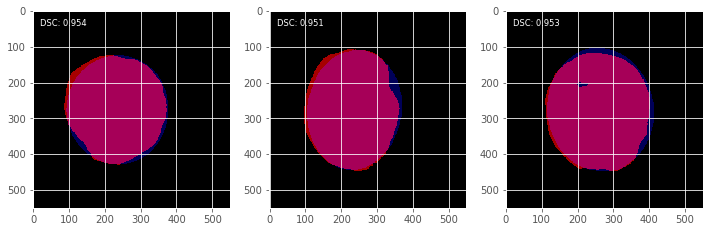

Evaluate fold  2

Epoch 00034: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00040: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 00045: ReduceLROnPlateau reducing learning rate to 1e-05.
Fold 2
loss: 0.0894 - acc: 0.964 - fscore: 0.948
after upscalling
loss: 0.0892 - acc: 0.973 - fscore: 0.949


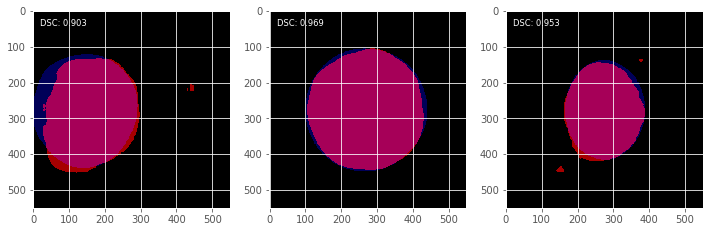

Evaluate fold  3

Epoch 00035: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00040: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 00045: ReduceLROnPlateau reducing learning rate to 1e-05.
Epoch 00050: early stopping
Fold 3
loss: 0.0912 - acc: 0.962 - fscore: 0.942
after upscalling
loss: 0.0910 - acc: 0.971 - fscore: 0.943


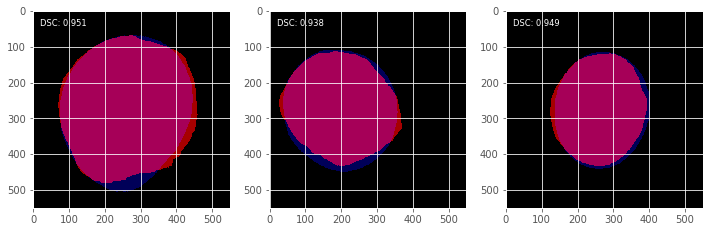

Evaluate fold  4

Epoch 00036: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00042: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 00047: ReduceLROnPlateau reducing learning rate to 1e-05.
Fold 4
loss: 0.0957 - acc: 0.962 - fscore: 0.943
after upscalling
loss: 0.0954 - acc: 0.971 - fscore: 0.945


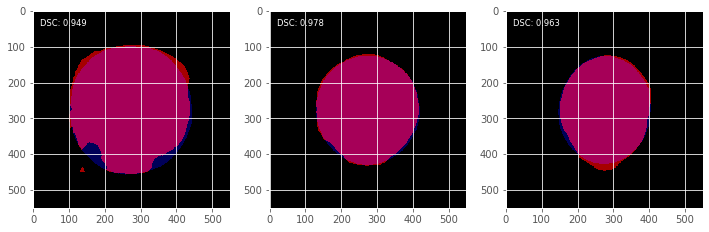

Evaluate fold  5

Epoch 00029: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00036: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 00041: ReduceLROnPlateau reducing learning rate to 1e-05.
Fold 5
loss: 0.0967 - acc: 0.960 - fscore: 0.939
after upscalling
loss: 0.0965 - acc: 0.969 - fscore: 0.940


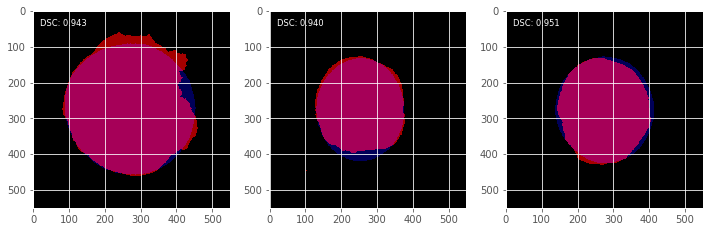


Best model is fold- 2


In [19]:
results_OD, metrics_OD = k_fold_crossval(X, y_OD, y_OD_ori, callbacks_OD, 'OD', 
                                         k=5, random_state=4, save=0)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


Evaluate fold  1

Epoch 00019: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00032: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 00044: ReduceLROnPlateau reducing learning rate to 1e-05.
Fold 1
loss: 0.0591 - acc: 0.974 - fscore: 0.841
after upscalling
loss: 0.0591 - acc: 0.978 - fscore: 0.844


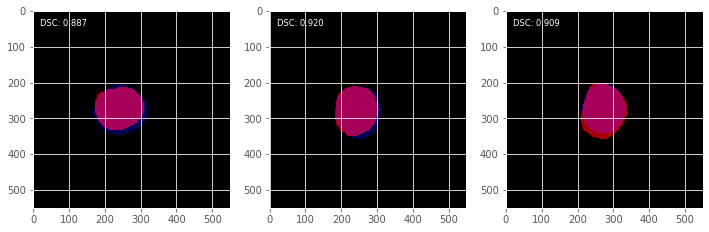

Evaluate fold  2

Epoch 00009: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00014: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 00019: ReduceLROnPlateau reducing learning rate to 1e-05.
Fold 2
loss: 0.0797 - acc: 0.965 - fscore: 0.768
after upscalling
loss: 0.0797 - acc: 0.969 - fscore: 0.772


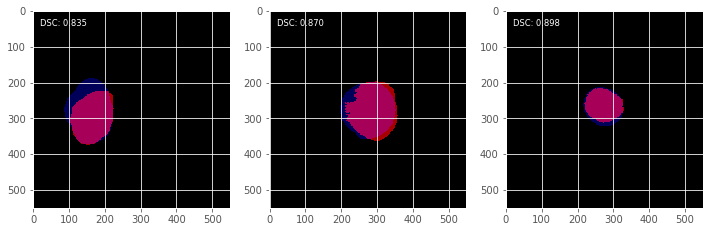

Evaluate fold  3

Epoch 00037: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00044: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 00049: ReduceLROnPlateau reducing learning rate to 1e-05.
Fold 3
loss: 0.0620 - acc: 0.974 - fscore: 0.857
after upscalling
loss: 0.0619 - acc: 0.978 - fscore: 0.860


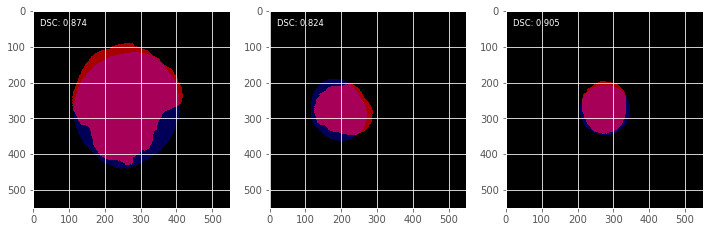

Evaluate fold  4

Epoch 00024: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00031: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 00044: ReduceLROnPlateau reducing learning rate to 1e-05.
Fold 4
loss: 0.0664 - acc: 0.973 - fscore: 0.857
after upscalling
loss: 0.0664 - acc: 0.977 - fscore: 0.860


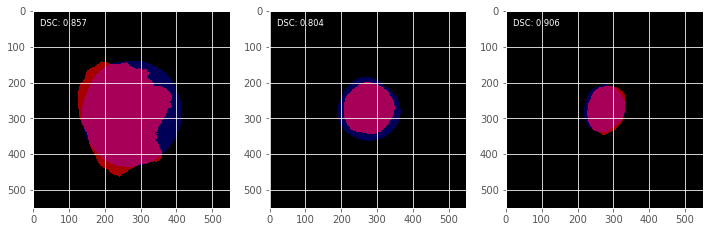

Evaluate fold  5

Epoch 00020: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00039: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 00044: ReduceLROnPlateau reducing learning rate to 1e-05.


In [ ]:
results_OC, metrics_OC = k_fold_crossval(X, y_OC, y_OC_ori, callbacks_OC, 'OC',
                                         k=5, random_state=4, save=0)

In [ ]:
metrics_OD.describe()

In [ ]:
metrics_OC.describe()

In [ ]:
histo(results_OD)

In [ ]:
histo(results_OC)

**Building Model**

In [ ]:
input_img = Input((256, 256, 1), name='img')

In [ ]:
model_OD = get_unet(input_img, n_filters = 64, dropout = 0.1, batchnorm = True)
model_OD.compile(optimizer=Adam(), loss="binary_crossentropy", metrics=['accuracy', fscore])

model_OC = get_unet(input_img, n_filters = 64, dropout = 0.1, batchnorm = True)
model_OC.compile(optimizer=Adam(), loss="binary_crossentropy", metrics=['accuracy', fscore])

In [ ]:
model_OD.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
img (InputLayer)                [(None, 256, 256, 1) 0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 256, 64) 640         img[0][0]                        
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 256, 256, 64) 256         conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 256, 256, 64) 0           batch_normalization_1[0][0]      
______________________________________________________________________________________________

In [ ]:
X_train_OD, X_test_OD, y_train_OD, y_test_OD = data_shuffle(X, y_OD, f=1, 
                                                            random_state=4)
X_train_OC, X_test_OC, y_train_OC, y_test_OC = data_shuffle(X, y_OC,f=1, 
                                                            random_state=4)
_, _, _, y_test_OD_ori = data_shuffle(X, y_OD_ori, f=1,random_state=4)
_, _, _, y_test_OC_ori = data_shuffle(X, y_OC_ori, f=1,random_state=4)

In [ ]:
for i, img in enumerate(X_train_OD[:10]):
  img_OD = img.squeeze()
  gt_OD = y_train_OD[i].squeeze()
  img_OC = X_train_OC[i].squeeze()
  gt_OC = y_train_OC[i].squeeze()
  plt.figure(figsize=(20, 5))
  plt.subplot(1,4,1)
  plt.imshow(img_OD)
  plt.subplot(1,4,2)
  plt.imshow(gt_OD)
  plt.subplot(1,4,3)
  plt.imshow(img_OC)
  plt.subplot(1,4,4)
  plt.imshow(gt_OC)
  plt.show()

In [ ]:
results_OD = model_OD.fit(X_train_OD, y_train_OD, batch_size=32, epochs=100, callbacks=callbacks_OD,\
                    validation_data=(X_test_OD, y_test_OD))

Epoch 1/100
12/12 [==============================] - 25s 2s/step - loss: 0.5853 - accuracy: 0.7130 - fscore: 0.5232 - val_loss: 1009.9367 - val_accuracy: 0.2434 - val_fscore: 0.4062

Epoch 00001: val_fscore improved from 0.00000 to 0.40620, saving model to model-OD.h5
Epoch 2/100
12/12 [==============================] - 16s 1s/step - loss: 0.2701 - accuracy: 0.8864 - fscore: 0.7720 - val_loss: 1718.8561 - val_accuracy: 0.2432 - val_fscore: 0.4061

Epoch 00002: val_fscore did not improve from 0.40620
Epoch 3/100
12/12 [==============================] - 17s 1s/step - loss: 0.1993 - accuracy: 0.9105 - fscore: 0.8294 - val_loss: 396.2518 - val_accuracy: 0.2441 - val_fscore: 0.4064

Epoch 00003: val_fscore improved from 0.40620 to 0.40641, saving model to model-OD.h5
Epoch 4/100
12/12 [==============================] - 17s 1s/step - loss: 0.1633 - accuracy: 0.9250 - fscore: 0.8649 - val_loss: 91.4019 - val_accuracy: 0.2673 - val_fscore: 0.4140

Epoch 00004: val_fscore improved from 0.40641 

In [ ]:
results_OC = model_OC.fit(X_train_OC, y_train_OC, batch_size=32, epochs=100, callbacks=callbacks_OC,\
                    validation_data=(X_test_OC, y_test_OC))

Epoch 1/100
12/12 [==============================] - 21s 1s/step - loss: 0.5746 - accuracy: 0.7262 - fscore: 0.4513 - val_loss: 2605.8665 - val_accuracy: 0.0680 - val_fscore: 0.1381

Epoch 00001: val_fscore improved from -inf to 0.13810, saving model to model-OC.h5
Epoch 2/100
12/12 [==============================] - 17s 1s/step - loss: 0.2114 - accuracy: 0.9534 - fscore: 0.6745 - val_loss: 226.4188 - val_accuracy: 0.0730 - val_fscore: 0.1387

Epoch 00002: val_fscore improved from 0.13810 to 0.13874, saving model to model-OC.h5
Epoch 3/100
12/12 [==============================] - 17s 1s/step - loss: 0.1787 - accuracy: 0.9547 - fscore: 0.6713 - val_loss: 142.9016 - val_accuracy: 0.0971 - val_fscore: 0.1420

Epoch 00003: val_fscore improved from 0.13874 to 0.14203, saving model to model-OC.h5
Epoch 4/100
12/12 [==============================] - 17s 1s/step - loss: 0.1621 - accuracy: 0.9552 - fscore: 0.7025 - val_loss: 73.9061 - val_accuracy: 0.1196 - val_fscore: 0.1452

Epoch 00004: val_

Fold-1


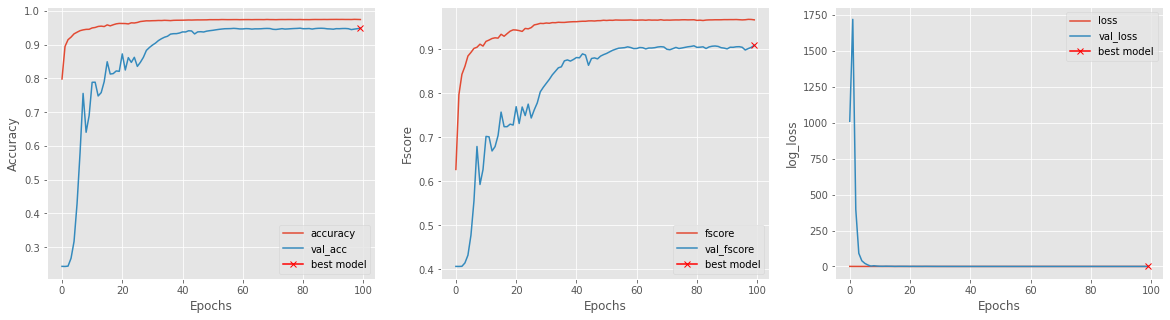

In [ ]:
histo([results_OD])

Fold-1


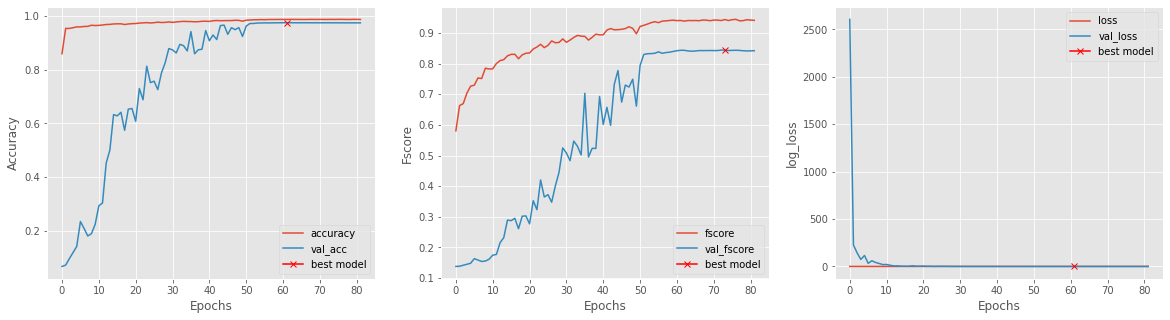

In [ ]:
histo([results_OC])

In [ ]:
# Load the best model
model_OD.load_weights('model-OD.h5')
model_OC.load_weights('model-OC.h5')

In [ ]:
# Adding Lambda layer at the end of model OD and OC
def add_lambda(model, X_test, y_test_ori):    
  model_layer = model.layers[-1]
  lu = Lambda(upscale, name="lambda_upscale")(model_layer.output)
  model_upscale = Model(model.input, lu, name="upscale_model")
  model_upscale.compile(loss="binary_crossentropy", metrics=["accuracy",fscore])
  model_upscale.evaluate(X_test, y_test_ori, verbose=1)
  return model_upscale

In [ ]:
model_OD_up = add_lambda(model_OD, X_test_OD, y_test_OD_ori)
model_OC_up = add_lambda(model_OC, X_test_OC, y_test_OC_ori)

3/3 [==============================] - 4s 388ms/step - loss: 0.0640 - accuracy: 0.9780 - fscore: 0.8369


In [ ]:
model_OD_up.save('/content/gdrive/My Drive/Drive Tugas Akhir/Kode/model OD semantic fixed/')
model_OC_up.save('/content/gdrive/My Drive/Drive Tugas Akhir/Kode/model OC semantic fixed/')

INFO:tensorflow:Assets written to: /content/gdrive/My Drive/Drive Tugas Akhir/Kode/model OD semantic fixed/assets
INFO:tensorflow:Assets written to: /content/gdrive/My Drive/Drive Tugas Akhir/Kode/model OC semantic fixed/assets


# Inference

In [ ]:
# load the best model
model.load_weights('model-tgs-salt.h5')

In [ ]:
model_OD_up = tf.keras.models.load_model('/content/gdrive/My Drive/Drive Tugas Akhir/Kode/model OD semantic fixed/', custom_objects={'fscore':fscore})
model_OC_up = tf.keras.models.load_model('/content/gdrive/My Drive/Drive Tugas Akhir/Kode/model OC semantic fixed/', custom_objects={'fscore':fscore})

In [ ]:
# Evaluate on validation set (this must be equals to the best log_loss)
model_OD.evaluate(X_test_OD, y_test_OD, verbose=1)
model_OC.evaluate(X_test_OC, y_test_OC, verbose=1)

3/3 [==============================] - 3s 331ms/step - loss: 0.0641 - accuracy: 0.9736 - fscore: 0.8343


[0.06344515830278397, 0.9737382531166077, 0.844048261642456]

In [ ]:
# Evaluate on validation set (this must be equals to the best log_loss)
model_OD_up.evaluate(X_test_OD, y_test_OD_ori, verbose=1)
model_OC_up.evaluate(X_test_OC, y_test_OC_ori, verbose=1)

3/3 [==============================] - 1s 387ms/step - loss: 0.0634 - accuracy: 0.9782 - fscore: 0.8466


[0.0633607804775238, 0.9782199263572693, 0.8466160297393799]

In [ ]:
# Predict on train, val and test
preds_train_OD = model_OD_up.predict(X_train_OD, verbose=1)
preds_val_OD = model_OD_up.predict(X_test_OD, verbose=1)
preds_train_OC = model_OC_up.predict(X_train_OC, verbose=1)
preds_val_OC = model_OC_up.predict(X_test_OC, verbose=1)

3/3 [==============================] - 1s 407ms/step


In [ ]:
# Threshold predictions
preds_train_t_OD = (preds_train_OD > 0.5).astype(np.uint8)
preds_val_t_OD = (preds_val_OD > 0.5).astype(np.uint8)
preds_train_t_OC = (preds_train_OC > 0.5).astype(np.uint8)
preds_val_t_OC = (preds_val_OC > 0.5).astype(np.uint8)

In [ ]:
# Circle Hough Transform Model fitting
def ellipsTransform(mask):
  # Select largest contour
  cnts, _= cv2.findContours(mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
  cnts = sorted(cnts, key=cv2.contourArea, reverse=True)
  elips = np.zeros((mask.shape[0], mask.shape[1]),np.uint8)
  if len(cnts)>0:
  # Ellipse fitting
    ellipse = cv2.fitEllipse(cnts[0])
    elips = cv2.ellipse(elips, ellipse, 255, cv2.FILLED)
  else:
    elips = mask
  return elips

In [ ]:
def ellips_fitting(preds):
  ellipsfitted = []
  for mask in preds:
    mask = mask.squeeze()
    mask = ellipsTransform(mask)
    mask = np.expand_dims(mask, axis=-1)
    ellipsfitted.append(mask)
  
  ellipsfitted = np.array(ellipsfitted)
  return ellipsfitted

In [ ]:
# Ellips fitting prediction
pred_val_el_OD = ellips_fitting(preds_val_t_OD)/255.0
pred_val_el_OC = ellips_fitting(preds_val_t_OC)/255.0

In [ ]:
# Mean Fscore calculation
def MeanFscore(pred_val, y_test_ori):
  Fscore = []
  for i, mask in enumerate(pred_val):
    mask = mask.squeeze()
    gt = y_test_ori[i].squeeze()
    DSC = np.sum(mask[gt==1.0])*2 / (np.sum(mask) + np.sum(gt))
    Fscore.append(DSC)

  Fscore = np.array(Fscore)
  mean = np.mean(Fscore)
  std = np.std(Fscore)
  max = np.max(Fscore)
  min = np.min(Fscore)
  print('Mean Fscore: {:.3f} - STD Fscore: {:.3f} - max Fscore: {:.3f} - min Fscore: {:.3f}'.\
        format(mean, std, max, min))

MeanFscore(pred_val_el_OD, y_test_OD_ori)
MeanFscore(pred_val_el_OC, y_test_OC_ori)

Mean Fscore: 0.924 - STD Fscore: 0.039 - max Fscore: 0.973 - min Fscore: 0.776
Mean Fscore: 0.844 - STD Fscore: 0.082 - max Fscore: 0.960 - min Fscore: 0.486


In [ ]:
# Total Fscore calculation
acc_m = tf.keras.metrics.BinaryAccuracy()
loss_m = tf.keras.metrics.BinaryCrossentropy()

acc_m.update_state(pred_val_el_OD, y_test_OD_ori)
loss_m.update_state(pred_val_el_OD, y_test_OD_ori)

acc = acc_m.result().numpy()
f1 = fscore(pred_val_el_OD, y_test_OD_ori)
loss = loss_m.result().numpy()
print('OD segmentation')
print('loss: {:.3f} - accuracy: {:.3f} - fscore: {:.3f}'.format(loss, acc, f1))

acc_m.reset_state()
loss_m.reset_state()

acc_m.update_state(pred_val_el_OC, y_test_OC_ori)
loss_m.update_state(pred_val_el_OC, y_test_OD_ori)
acc = acc_m.result().numpy()
f1 = fscore(pred_val_el_OC, y_test_OC_ori)
loss = loss_m.result().numpy()
print('OC segmentation')
print('loss: {:.3f} - accuracy: {:.3f} - fscore: {:.3f}'.format(loss, acc, f1))

OD segmentation
loss: 0.552 - accuracy: 0.964 - fscore: 0.926
OC segmentation
loss: 2.810 - accuracy: 0.979 - fscore: 0.854


In [ ]:
import scipy.ndimage
import cv2
def plot_sample(X, y, preds, binary_preds, ix=None):
    """Function to plot the results"""
    if ix is None:
        ix = random.randint(0, len(X))

    has_mask = y[ix].max() > 0

    fig, ax = plt.subplots(1, 4, figsize=(20, 10))
    ax[0].imshow(X[ix, ..., 0], cmap='gray')
    if has_mask:
        ax[0].contour(y[ix].squeeze(), colors='k', levels=[0.5])
    ax[0].set_title('Seismic')

    ax[1].imshow(y[ix].squeeze(), cmap='gray')
    ax[1].set_title('Salt')

    ax[2].imshow(preds[ix].squeeze(), vmin=0, vmax=1)
    if has_mask:
        ax[2].contour(y[ix].squeeze(), colors='k', levels=[0.5])
    ax[2].set_title('Salt Predicted')
    
    ax[3].imshow(binary_preds[ix].squeeze(), vmin=0, vmax=1)
    if has_mask:
        ax[3].contour(y[ix].squeeze(), colors='k', levels=[0.5])
    ax[3].set_title('Salt Predicted binary');


# Plot image

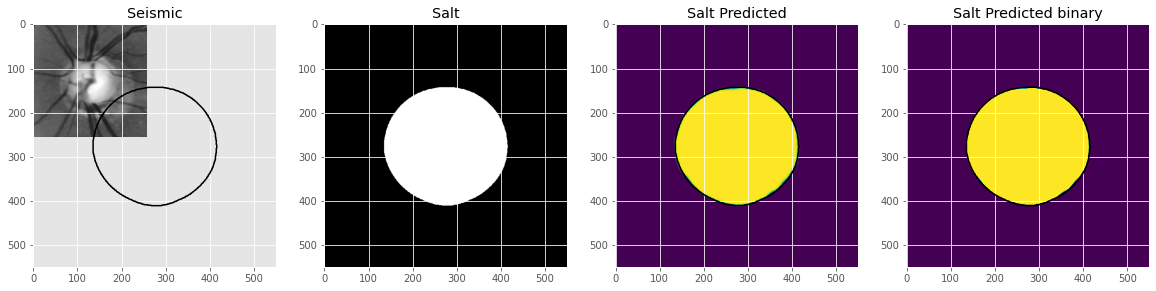

In [ ]:
# Check if training data looks all right
plot_sample(X_test_OD, y_test_OD_ori, preds_val_OD, preds_val_t_OD, ix=30)

In [ ]:
plot_sample(X_train_OC, y_train_OC, preds_train_OC, preds_train_t_OC, ix=30)

In [ ]:
plot_sample(X_train_OD, y_train_OD, preds_train_OD, preds_train_t_OD, ix=1)

In [ ]:
plot_sample(X_train_OC, y_train_OC, preds_train_OC, preds_train_t_OC, ix=1)

# Saving model

In [ ]:
model_OD.save('/content/gdrive/My Drive/Drive Tugas Akhir/Kode/model OD semantic/')
model_OC.save('/content/gdrive/My Drive/Drive Tugas Akhir/Kode/model OC semantic/')